In [1]:
from FeedForwardNN import Feedforward
from Toy_Datasets import two_clusters_gaussian
from Neural_Network import NLM
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
from autograd.misc.optimizers import adam
from Bayesian_pdf import get_log_prior, get_log_likelihood
from Hamiltonian_MC import hmc

In [2]:
def two_clusters_gaussian(params, n_samples, test_points=None):
    """
    :param params: should be a list of length K, K being the number of classes you wish to create
    for every class 0 <= k <=K-1, params[k] should be a dictionnary containing two keys: mean and covariance_matrix.
    The shapes expected for mean are D and covariance_matrix are D*D where D is the number of features for every
    datapoint.
    :param n_samples: number of samples you wish to create for every cluster
    :param test_points: OOD points
    :return: x of len(K*n_samples, n_features) and y of shape (K*n_samples). For both x and y, the features pertain
    sequentially to every class 0 <= k <= K-1
    """
    if params:
        if isinstance(params, list):  # params is a list
            K = len(params)
        else:  # params is a numpy array
            K = params.shape[0]	
        x = np.array([0, 0])
        for k, param in enumerate(params):
            param_k = params[k]
            try:
                mean_k, cov_k = param_k['mean'], param_k['covariance_matrix']
            except KeyError:
                raise KeyError('The parameters for class ' + str(k) + 'are not in the right dictionnary format. Please use mean and covariance_matrix')
            assert len(mean_k) == cov_k.shape[0] == cov_k.shape[1], 'Wrong shapes for the parameters of class ' + str(k)
            samples_class_k = np.random.multivariate_normal(mean_k, cov_k, n_samples)
            x = np.vstack((x, samples_class_k))
        y = np.array([[k] * n_samples for k in range(K)])
        return x[1:, :], np.array(y).flatten()
    else:
        raise BaseException().args

In [3]:
def plot_decision_boundary(x, y, models, ax, poly_degree=1, test_points=None, shaded=True):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       models - an array of classification models
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
       test_points - test data
       shaded - whether or not the two sides of the decision boundary are shaded
    returns: 
       ax - the axis with the scatter plot

    '''
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='class 1')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='class 0')
    ax.scatter(x[y == 2, 0], x[y == 2, 1], alpha=0.2, color='green', label='class 2')


    # Create mesh
    interval = np.arange(-5, 5, 0.1)
    n = np.size(interval)
    print(n)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_degree > 1):
        polynomial_features = PolynomialFeatures(degree=poly_degree, include_bias=True)
        xx = polynomial_features.fit_transform(xx)

    if len(models) > 1:
        alpha_line = 0.1
        linewidths=0.1
    else:
        alpha_line = 0.8
        linewidths=0.5

    i = 0

    for model in models:
        yy = model.predict(xx)  
        yy = yy.reshape((n, n))

        # Plot decision surface
        x1 = x1.reshape(n, n)
        x2 = x2.reshape(n, n)
        if shaded:
            ax.contourf(x1, x2, yy, alpha=0.1 * 1. / (i + 1)**2, cmap='bwr')
        ax.contour(x1, x2, yy, colors='black', linewidths=linewidths, alpha=alpha_line)

        i += 1

    if test_points is not None:
        for i in range(len(test_points)):
            pt = test_points[i]
            if i == 0:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
            else:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')

    ax.set_xlim((-5.5, 5.5))
    ax.set_ylim((-5.5, 5.5))
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.legend(loc='best')
    return ax

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Bayesian_logistic_regression:
    def __init__(self, intercept, slopes):
        self.intercept = intercept
        self.slopes = slopes

    def predict(self, x):
        print(x.shape)
        print(self.slopes.shape)
        #y = sigmoid((x.reshape(-1,20)).dot(self.slopes) + self.intercept)
        y = sigmoid((x).dot(self.slopes) + self.intercept)
        return (y > 0.5).astype(np.int_)

    def predict_proba(self, x):
        return sigmoid(x.dot(self.slopes) + self.intercept)

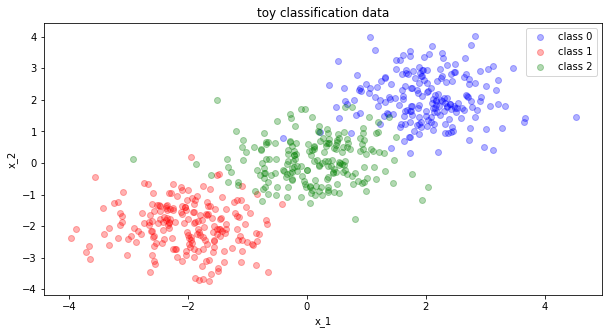

In [4]:
params_1 = {'mean': [2, 2], 'covariance_matrix': 0.5*np.eye(2)}
params_2 = {'mean': [-2, -2], 'covariance_matrix': 0.5 * np.eye(2)}
params_3 = {'mean': [0, 0], 'covariance_matrix': 0.5 * np.eye(2)}
params = [params_1, params_2,params_3]
x, y = two_clusters_gaussian(params, 200)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 2, 0], x[y == 2, 1], alpha=0.3, color='green', label='class 2')

ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data')
ax.legend(loc='best')
plt.show()

# test BNN
* 3 classes
* output dim =1
* 2000 samples, step size 1e-2


In [5]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 2
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

In [8]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn.fit(x.T, y.reshape(1,-1), params)
#nn.fit(x.T, y.reshape(3,-1), params)

Iteration 0 lower bound [2878.58142705]; gradient mag: 1792.341722249051
Iteration 100 lower bound [2345.53392195]; gradient mag: 1652.732104526413
Iteration 200 lower bound [1837.72600291]; gradient mag: 1535.9597845965454
Iteration 300 lower bound [1381.67497463]; gradient mag: 1268.5559520992047
Iteration 400 lower bound [1063.0000556]; gradient mag: 854.6612670635143
Iteration 500 lower bound [833.91835352]; gradient mag: 705.18438901048
Iteration 600 lower bound [562.67301339]; gradient mag: 767.588951598304
Iteration 700 lower bound [227.77019326]; gradient mag: 831.5919232076081
Iteration 800 lower bound [-61.74577746]; gradient mag: 770.1890785272813
Iteration 900 lower bound [-275.66181284]; gradient mag: 688.2818670636366
Iteration 1000 lower bound [-446.58983265]; gradient mag: 648.1653759215062
Iteration 1100 lower bound [-602.87025054]; gradient mag: 642.1251258295978
Iteration 1200 lower bound [-759.02700536]; gradient mag: 655.579822186196
Iteration 1300 lower bound [-92

Iteration 10700 lower bound [-6709.11139537]; gradient mag: 10.606838862161787
Iteration 10800 lower bound [-6710.46125256]; gradient mag: 28.326370801734583
Iteration 10900 lower bound [-6711.37106792]; gradient mag: 13.957284039450316
Iteration 11000 lower bound [-6712.25684582]; gradient mag: 13.67816309301631


/Users/gaelancel/anaconda3/lib/python3.5/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))


Iteration 11100 lower bound [-6713.21912724]; gradient mag: 15.80625790952774
Iteration 11200 lower bound [-6714.07401444]; gradient mag: 16.292140609832927
Iteration 11300 lower bound [-6715.09396662]; gradient mag: 28.47643623964849
Iteration 11400 lower bound [-6715.86613733]; gradient mag: 20.712023358012985
Iteration 11500 lower bound [-6716.55540958]; gradient mag: 6.201623652005573
Iteration 11600 lower bound [-6717.28796723]; gradient mag: 16.54093248252807
Iteration 11700 lower bound [-6717.80374243]; gradient mag: 11.881393568452731
Iteration 11800 lower bound [-6718.503306]; gradient mag: 13.3280618488312
Iteration 11900 lower bound [-6719.05042741]; gradient mag: 13.779563671296282
Iteration 12000 lower bound [-6719.52733969]; gradient mag: 10.142055342250552
Iteration 12100 lower bound [-6720.11347525]; gradient mag: 10.4802123012541
Iteration 12200 lower bound [-6720.74752152]; gradient mag: 12.44467179374495
Iteration 12300 lower bound [-6721.27188932]; gradient mag: 11.

In [15]:
nn.forward(nn.weights,x.T).reshape(3,-1)

array([[3.71933538e-010, 9.10227913e-082, 2.96278218e-091,
        2.55964933e-174, 1.07414765e-076, 4.00206113e-097,
        1.41976838e-021, 1.00000000e+000, 3.27052385e-049,
        9.92799291e-080, 3.80269484e-040, 5.63807066e-060,
        4.15416060e-114, 1.53970185e-127, 7.95798543e-136,
        1.76074853e-037, 4.37944870e-173, 9.47127570e-055,
        6.79222699e-071, 1.54465344e-128, 1.51030456e-167,
        4.26829466e-126, 2.48907921e-029, 1.54276083e-102,
        6.54203122e-135, 1.57240765e-066, 1.15481781e-114,
        4.21356480e-050, 2.21165271e-096, 1.30945028e-092,
        4.42520306e-044, 1.74832946e-049, 1.88681836e-061,
        2.07934134e-089, 2.82115022e-113, 4.25855819e-129,
        8.30128796e-096, 1.12652314e-070, 1.51969942e-087,
        2.73595580e-081, 3.73316323e-140, 1.30606994e-111,
        1.37105717e-118, 3.51463065e-153, 3.36381151e-073,
        2.24115465e-047, 3.47111907e-123, 1.66949131e-106,
        3.96580904e-022, 9.16374285e-052, 6.47060599e-06

In [ ]:
params_hmc={
       'num_samples':2000,
       'step_size':1e-2, 
       'L':20,
       'init': nn.weights,
       'burn':.1, 
       'thin':2,
}


def log_prior(W):
    Sigma=25*np.eye(nn.D)
    D_bayes=Sigma.shape[0]
    Sigma_inv= np.linalg.inv(Sigma)
    Sigma_det = np.linalg.det(Sigma)
    constant_W = -0.5 * (D_bayes * np.log(2 * np.pi) + np.log(Sigma_det))
    exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_inv), W.T))
    log_p_W = constant_W + exponential_W
    return log_p_W

def log_likelihood(W):
    D_bayes=len(y.reshape((-1,1)))
    sigma_y=0.5
    constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * D_bayes
    exponential = -0.5 * sigma_y**-2 * np.sum((y.reshape((1, 1, D_bayes)) - nn.forward(W, x.T))**2, axis=2).flatten()
    return constant + exponential



In [ ]:
q=hmc(log_prior, log_likelihood, **params_hmc)

In [16]:
q_=np.asarray(q).T
plt.plot(range(len(q_[-1])),q_[-1] , color='r')
plt.title('BNN posterior')
plt.show()
print(nn.weights)

NameError: name 'q' is not defined

In [ ]:
# Plot the decision boundary for the learned model
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
model=Bayesian_logistic_regression(nn.weights[0][-1],nn.weights[0][:-1])
ax = plot_decision_boundary(x, y, [model], ax, poly_degree=1,  shaded=True)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

# test BNN
* 3 classes
* output dim =3
* 2000 samples, step size 1e-2m

In [23]:
class Feedforward:

    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = ((architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width'] ** 2 + architecture['width'])
                  )  # in order: input, output, hidden. Take into account the biases

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))

    def forward(self, weights, x):
        """ Forward pass given weights and input """
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']
        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T

        # input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        # additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        def softmax(y):   
            return np.exp(y - np.max(y))/(np.exp(y - np.max(y)).sum())

        def sigmoid(y):   
            return 1/(1 + np.exp(-y))

       # output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = softmax(np.matmul(W, input) + b)  # review that for training
        assert output.shape[1] == self.params['D_out']

        return output

    def make_objective(self, x_train, y_train, reg_param):

        def objective(W, t):
            sigmoid_probability = self.forward(W, x_train)
            sigmoid_probability = np.clip(sigmoid_probability, 1e-15, 1 - 1e-15)
            #bce = np.dot(np.log(sigmoid_probability),y_train.flatten()) + np.dot(np.log(1 - sigmoid_probability),(1 - y_train.flatten())) ##true only for k=2
            bce = np.dot(np.log(sigmoid_probability),y_train.flatten()).sum()
            if reg_param is None:
                sum_error = bce
                return -sum_error
            else:
                mean_error = bce + reg_param * np.linalg.norm(W)
                return -mean_error

        return objective, grad(objective)

    def fit(self, x_train, y_train, params, reg_param=None):

        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']

        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(
                    self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

In [24]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 3
input_dim = 2
output_dim = 3

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn2 = Feedforward(architecture, random=random)

In [25]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn2.fit(x.T, y.reshape(3,-1), params)

Iteration 0 lower bound 14165.294475406648; gradient mag: 5071.668682035805
Iteration 100 lower bound 13788.87047953952; gradient mag: 612.3718546373932
Iteration 200 lower bound 13695.172990709412; gradient mag: 531.2357939769743
Iteration 300 lower bound 13616.53074286403; gradient mag: 463.05309810446926
Iteration 400 lower bound 13459.10314177232; gradient mag: 513.6961987177307
Iteration 500 lower bound 13222.993835211098; gradient mag: 541.735473886132
Iteration 600 lower bound 13004.788113682669; gradient mag: 346.08057887260475
Iteration 700 lower bound 12906.01765214257; gradient mag: 161.76726890909373
Iteration 800 lower bound 12834.542486895863; gradient mag: 99.19997810589678
Iteration 900 lower bound 12808.595820218983; gradient mag: 75.2084675907192
Iteration 1000 lower bound 12794.16745257695; gradient mag: 52.59501054539058
Iteration 1100 lower bound 12787.311152857264; gradient mag: 36.52231945902835
Iteration 1200 lower bound 12782.9097393224; gradient mag: 32.511163

Iteration 10400 lower bound 12750.690522562567; gradient mag: 10.89560398330707
Iteration 10500 lower bound 12750.692907965058; gradient mag: 25.633982024956282
Iteration 10600 lower bound 12750.690815844337; gradient mag: 11.93269909345627
Iteration 10700 lower bound 12750.69172990986; gradient mag: 23.133831356561984
Iteration 10800 lower bound 12750.687392584232; gradient mag: 10.058841531870167
Iteration 10900 lower bound 12750.686843108906; gradient mag: 20.027200010924894
Iteration 11000 lower bound 12750.684288698532; gradient mag: 10.149519516069315
Iteration 11100 lower bound 12750.68440620679; gradient mag: 12.53590803869931
Iteration 11200 lower bound 12750.683633429922; gradient mag: 14.879590267146098
Iteration 11300 lower bound 12750.683345758467; gradient mag: 32.903008202272
Iteration 11400 lower bound 12750.683868953827; gradient mag: 18.075277921934028
Iteration 11500 lower bound 12750.68618305781; gradient mag: 21.058550538831273
Iteration 11600 lower bound 12750.680

In [31]:
print(nn2.forward(nn2.weights,x.T)[0][0][:100],'\n')
print(nn2.forward(nn2.weights,x.T)[0][0][100:200],'\n')
print(nn2.forward(nn2.weights,x.T)[0][0][200:],'\n')

[3.86689670e-09 2.87449837e-05 2.87245684e-06 3.06354139e-05
 2.62519079e-09 2.21997666e-09 2.21997666e-09 2.21997666e-09
 8.64401789e-07 2.69113395e-04 4.16824332e-08 1.53026054e-05
 9.26882033e-08 4.45820676e-09 1.08025657e-07 5.84241334e-07
 1.44205773e-04 1.95657872e-04 7.50863268e-04 3.85065041e-05
 1.52084235e-06 8.66157897e-06 9.08486439e-04 7.69333399e-05
 1.01359768e-06 5.03395973e-08 5.85195231e-09 1.51810594e-07
 7.40353616e-07 1.09745164e-07 9.65714414e-09 2.21997666e-09
 1.18103529e-06 6.48008386e-04 6.72485174e-08 2.68654764e-06
 2.16443119e-06 8.93280550e-08 6.39125689e-08 2.21989161e-06
 3.32594280e-04 2.00472546e-06 3.83377515e-07 3.55582045e-06
 1.43050453e-06 2.61488329e-08 1.24120803e-07 9.11013126e-07
 2.21997666e-09 4.17862657e-06 1.19879811e-06 2.21997666e-09
 1.72046751e-06 2.42072423e-06 1.05411086e-03 1.44585935e-08
 2.21997666e-09 8.84879482e-08 3.99539757e-08 2.34561992e-08
 4.53008190e-05 1.10799956e-07 6.85374222e-05 1.65700033e-06
 6.05496607e-06 2.219976

In [50]:
params_hmc={
       'num_samples':2000,
       'step_size':1e-2, 
       'L':20,
       'init': nn2.weights,
       'burn':.1, 
       'thin':2,
}


def log_prior(W):
    Sigma=25*np.eye(nn2.D)
    D_bayes=Sigma.shape[0]
    Sigma_inv= np.linalg.inv(Sigma)
    Sigma_det = np.linalg.det(Sigma)
    constant_W = -0.5 * (D_bayes * np.log(2 * np.pi) + np.log(Sigma_det))
    exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_inv), W.T))
    log_p_W = constant_W + exponential_W
    return log_p_W

def log_likelihood(W):
    D_bayes=len(y.reshape((-1,1)))
    sigma_y=0.5
    constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * D_bayes
    #print(constant)
    exponential = (-0.5 * sigma_y**-2 * np.sum((y.reshape((1, 1, D_bayes)) - (nn2.forward(W, x.T)))**2, axis=2).flatten()).mean()
    #print(exponential)
    return constant + exponential

q=hmc(log_prior, log_likelihood, **params_hmc)


log_likelihood(nn2.weights)

100 : 0.99 False
200 : 0.925 False
300 : 0.9266666666666666 False
400 : 0.9025 False
500 : 0.878 False
600 : 0.89 False
700 : 0.8885714285714286 False
800 : 0.89 False
900 : 0.8966666666666666 False
1000 : 0.903 False
1100 : 0.8981818181818182 False
1200 : 0.8991666666666667 False
1300 : 0.8992307692307693 False
1400 : 0.9021428571428571 False
1500 : 0.9066666666666666 False
1600 : 0.9125 False
1700 : 0.9164705882352941 False
1800 : 0.9205555555555556 False
1900 : 0.9236842105263158 False


-2133.3492049562165

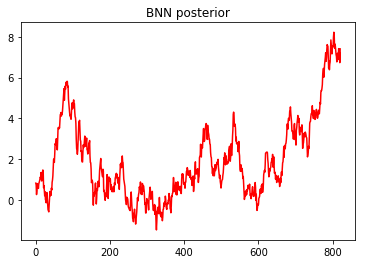

In [54]:
q_=np.asarray(q).T
plt.plot(range(len(q_[0])),q_[0] , color='r')
plt.title('BNN posterior')
plt.show()

# NLM

In [59]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 2
input_dim = 2
output_dim = 3

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'prior': 'normal',
               'prior_parameters':{'mean': np.array([1, 2]), 'covariance_matrix': np.eye(2)},
               'likelihood': 'logistic',
               'likelihood_parameters': {},
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nlm = NLM(architecture, random=random)

In [63]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
#nlm.fit_MLE(x.T, y.reshape(1,-1), params)
nlm.fit_MLE(x.T, y.reshape(3,-1), params)

Iteration 0 lower bound 12742.956496065595; gradient mag: 25.23026904129423
Iteration 100 lower bound 12742.876824189658; gradient mag: 38.52264512345793
Iteration 200 lower bound 12742.837934021889; gradient mag: 38.68473706887483
Iteration 300 lower bound 12741.48259335079; gradient mag: 53.0836878462019
Iteration 400 lower bound 12740.908834195212; gradient mag: 70.41640336147029
Iteration 500 lower bound 12740.42704604445; gradient mag: 44.35391190282769
Iteration 600 lower bound 12739.829821843945; gradient mag: 40.94904310163851
Iteration 700 lower bound 12739.224413104517; gradient mag: 61.80345815290504
Iteration 800 lower bound 12738.620482154354; gradient mag: 20.393157313092196
Iteration 900 lower bound 12738.236635508934; gradient mag: 38.62184494845143
Iteration 1000 lower bound 12737.922366567878; gradient mag: 21.995794413501056
Iteration 1100 lower bound 12737.679342453508; gradient mag: 73.72140846412928
Iteration 1200 lower bound 12737.41494859452; gradient mag: 27.99

Iteration 10400 lower bound 12713.951004943803; gradient mag: 178.2388980947958
Iteration 10500 lower bound 12714.021127554563; gradient mag: 368.85121010803067
Iteration 10600 lower bound 12713.87198049348; gradient mag: 122.12080818594332
Iteration 10700 lower bound 12713.912070108434; gradient mag: 427.89727133396315
Iteration 10800 lower bound 12713.766301149528; gradient mag: 414.24627035795527
Iteration 10900 lower bound 12713.727386543998; gradient mag: 98.0826963698317
Iteration 11000 lower bound 12713.803471347766; gradient mag: 126.62774789584302
Iteration 11100 lower bound 12713.56837256366; gradient mag: 108.87271808112293
Iteration 11200 lower bound 12713.588519522702; gradient mag: 413.24869120533
Iteration 11300 lower bound 12713.50832277852; gradient mag: 150.45586262100244
Iteration 11400 lower bound 12713.512358205875; gradient mag: 135.48159415155067
Iteration 11500 lower bound 12713.474793515237; gradient mag: 141.98064124444707
Iteration 11600 lower bound 12713.600

In [74]:
params_hmc={
       'num_samples':2000,
       'step_size':1e-2, 
       'L':20,
       'init': nlm.weights,
       'burn':.1, 
       'thin':2,}

nlm.forward(nlm.weights, x.T)[0][0]

array([5.83544809e-42, 8.83199202e-16, 1.71965044e-10, 4.54158409e-16,
       1.00380719e-46, 1.24746415e-51, 2.11028461e-65, 2.72093556e-48,
       1.37467072e-12, 6.15690059e-05, 2.64806687e-26, 1.12287625e-13,
       9.83015125e-27, 2.63491273e-43, 5.53678901e-24, 2.96955615e-17,
       7.21997766e-09, 2.97425415e-14, 5.28135615e-04, 2.08210283e-06,
       5.55447325e-14, 8.64994780e-20, 9.13665316e-04, 3.33177704e-15,
       6.52536253e-19, 1.24326667e-32, 6.16161806e-42, 4.75732440e-26,
       7.12127523e-29, 7.40925895e-25, 1.30057587e-47, 1.96722559e-70,
       1.86777906e-12, 3.53016140e-05, 9.45229425e-27, 2.93325956e-10,
       3.45192098e-13, 2.02090843e-26, 4.59656478e-27, 3.47049794e-16,
       8.56725883e-07, 1.06183737e-18, 2.39249818e-27, 1.91773849e-17,
       1.82627055e-26, 6.78112693e-24, 1.79293897e-26, 6.58044384e-26,
       2.33722821e-55, 9.86670155e-22, 2.29976450e-16, 1.10117653e-47,
       4.78972975e-09, 6.71921874e-16, 1.90884422e-06, 2.57544317e-29,
      

In [11]:
print(nlm.weights.shape)
nlm.fit_NLM(x.T, y.reshape(1,-1),hmc,params_hmc)

(1, 63)
[[[ 8.13247077  1.629539    3.44835104 ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  1.4144595   1.51391366
    1.2719105 ]
  [14.25172137 10.80294046 11.16547419 ...  1.77435123  1.36291273
    2.22798707]]] (1, 5, 600)
[[ 2.43504153  0.90469757  2.09587105 ... -0.38379057 -0.25698593
  -1.10258657]
 [ 2.58546245  2.27212216  1.28687207 ... -0.25224376 -0.50370283
   0.51680035]]


ValueError: shapes (1,63) and (1,5,600) not aligned: 63 (dim 1) != 5 (dim 1)